<img style="float: left;" src="https://d3rt91u8ecpt22.cloudfront.net/assets/learn/logo-exts-0e71782f000e506b332ae30887d6a959dd3a13bcc0d6fb6bb7797c4f1100a537.svg" alt="drawing" width="100"/> 

# Capstone Project - Liberty Mutual Group Fire Peril Loss Cost
***Author: Alexander Donders***
***

## Table of Contents

1. [Objectives & Intentions](#1)
2. [Importing the Data](#2)
3. [Cleaning the Data](#3)
4. [Exploratory Data Analysis](#4)
5. [Feature Engineering](#5)
6. [Model Evaluation Metric](#6)
7. [Model Building](#7)
    - 7.1. [Model Building Process](#71)
    - 7.2. [Regression & Classification Ensemble](#72)
    - 7.3. [Ensemble Stacking & Blending](#73)
    - 7.4. [Training a Meta Learner](#74)
    - 7.5. [Validating a Meta Learner](#75)
    
8. [Final Prediction & Submission](#8)
9. [Conclusion & Discussion](#9)
10. [References](#10)
***

## 1. Objectives & Intention <a name="1"></a>

In this capstone project, we are going to look at a challenge from the insurance sector that was hosted on [Kaggle](https://www.kaggle.com/c/liberty-mutual-fire-peril). 

The training set bears several interesting aspects that distinguish this challenge from others. Firstly, the highly imbalanced dataset with over 300 variables makes the use of regression algorithms particularly difficult. Secondly, the meaning of the variables in the dataset is completely unknown. While the first aspect introduces the need for techniques that manage the extreme imbalance in the dataset, the second aspect renders any particular business knowledge in the insurance industry useless as no meaning whatsovever can be obtained from the standardised and anonmymised variables. 

However, the quality of the dataset is very high. This allows for less cleaning and preprocessing and more time to explore new techniques to tackle the actual challenge of building a robust model to predict the loss-to-insured value ratio.

Therefore, the question that arises is stated as follows:

*** How can a valid prediction model be built that manages extremely imbalanced data and builds upon features that are unknown to the machine learning engineer or data scientist? ***

The following figure summarises the problem as well as the intention and objective:

<img style="float: left;" src="Pictures\challenge.png" alt="drawing" width="1086"/> 

In [1]:
#init libraries
import warnings;
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.externals import joblib
import zipfile
import os

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.linear_model import LogisticRegression, RandomizedLasso, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor

from xgboost import XGBRegressor
from scipy import stats
from scipy import sparse

%matplotlib inline
#set notebook display options to display the entire printed dataset (if needed)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)     # or 1000
pd.set_option('display.max_colwidth', -1)   # or 199

## 2. Importing the Data <a name="2"></a>

First, we import the data. Note that we know from the `Data Description`-page on the Kaggle-website, that missing values are denoted using the values "Z" and "NA". Also, during the course of the project, values of type `np.nan` were encountered that led to unexpected behaviour of certain functions. 

In [2]:
#prepare data frames
zf = zipfile.ZipFile('loss-cost.zip') 
df = pd.read_csv(zf.open('train.csv'), na_values=['NA', 'Z', 'nan', np.nan])
df_test = pd.read_csv(zf.open('test.csv'), na_values=['NA', 'Z', 'nan', np.nan])
df_test_ex = pd.read_csv(zf.open('sampleSubmission.csv'))

In [3]:
def get_df_overview(df, sort):
    c = pd.DataFrame({'Count': df.count()})
    dt = pd.DataFrame({'dType': df.dtypes})
    n = pd.DataFrame({'nulls': df.isnull().sum()})
    npct = pd.DataFrame({'nulls pct': df.isnull().sum() / len(df)})
    nn = pd.DataFrame({'not nulls': df.notnull().sum()})

    cols = [df[col].duplicated().sum() for col in df.columns]
    d = pd.DataFrame({'':pd.Series(c.index),'duplicates': cols}).set_index('')
    d.duplicates = d.duplicates - n.nulls + 1
    dpct = pd.DataFrame({'duplicates pct': (d.duplicates) / len(df)})
    
    cols = []
    for col in df.columns:
        if df[col].notnull().sum() > 0:
            cols.append(df[df[col].notnull()].iloc[0,df.columns.get_loc(col)])
        else:
            cols.append("NaN")
    
    f = pd.DataFrame({'': pd.Series(c.index), 'first value': pd.Series(cols)}).set_index('')

    info = c.join(dt).join(n).join(npct).join(nn).join(d).join(dpct).join(f)
    info.sort_values([sort], ascending=[False], inplace=True)
    return info

In [4]:
df.head()

id  target  var1 var2  var3 var4 var5 var6  var7  var8 var9     var10  \
0  1   0.0    NaN    NaN NaN    N1   NaN  NaN  3.0   1.0   A    3.898949   
1  2   0.0    NaN    NaN NaN    C1   NaN  NaN  3.0   2.0   A    3.898949   
2  3   0.0     3.0   NaN  4.0   J3   B    B    2.0   4.0   NaN  4.314082   
3  4   0.0     3.0   NaN  4.0   H1   B    NaN  3.0   4.0   NaN  4.314082   
4  5   0.0    NaN    NaN NaN    H1   NaN  NaN  2.0   4.0   A    3.898949   

         var11     var12     var13  var14  var15  var16       var17 dummy  \
0  705.907218  NaN        0.000000  0.0    29.0  NaN     84.337349   A      
1  778.939664  NaN        1.268636 NaN     23.0  NaN     100.000000  A      
2  686.728476   2.719846  2.482178  0.0   NaN     100.0  0.000000    B      
3  3515.206111  3.520478  2.054144  0.0    22.0   100.0  100.000000  B      
4  1014.569367 NaN        0.832555 NaN     21.0  NaN     2.421308    A      

   crimeVar1  crimeVar2  crimeVar3  crimeVar4  crimeVar5  crimeVar6  \
0  0.868651   0.625186   0.685535   0.698889   1.322650   1.036953    
1  1.049803   0.668872   0.902722   0.658104   1.679865   0.505010    
2  1.887331   1.513871   1.274002   1.256733   1.046967   1.070620    
3  1.659096   1.341626   0.957322   1.328928   0.661204   1.232223    
4  0.894055   1.380088   1.133255   1.249629   1.258417   0.922484    

   crimeVar7  crimeVar8  crimeVar9  geodemVar1  geodemVar2  geodemVar3  \
0  0.739831   1.233004   0.985852   2.907669    1.190971    1.085760     
1  0.754489   0.887022   0.977406   3.291752    1.108728    1.009916     
2  1.302359   1.122016   1.572879   2.437528    0.942239    1.061809     
3  1.276299   0.904233   1.346898   0.301106    0.767103    0.870204     
4  1.285127   1.022282   0.954293   1.259461    1.059423    1.029875     

   geodemVar4  geodemVar5  geodemVar6  geodemVar7  geodemVar8  geodemVar9  \
0  1.214415    4.186556    2.711295    0.902699    2.682806    1.036433     
1  1.163157    4.376695    2.370791    0.894850    2.690246    1.003267     
2  1.029098    2.927603    0.911176    0.753558    0.807826    1.015704     
3  1.080356    0.920084    0.197981    2.394116    0.872650    0.671609     
4  1.048813    3.182098    1.209454    0.682912    1.206430    1.173242     

   geodemVar10  geodemVar11  geodemVar12  geodemVar13  geodemVar14  \
0  2.624847     2.632027     0.530775     1.934022     0.702882      
1  2.569522     2.655512     1.844761     3.520036     1.283554      
2  0.926616     0.944779     0.826123     0.944326     0.963204      
3  0.207778     0.321540     0.370501     0.371143     1.091631      
4  1.762718     1.556458     0.937147     3.762755     2.352705      

   geodemVar15  geodemVar16  geodemVar17  geodemVar18  geodemVar19  \
0  1.957826     0.977705     2.430076     0.642147     1.351742      
1  4.074402     1.015829     2.584384     3.417460     1.134306      
2  0.869176     1.005991     0.873743     0.738184     0.914992      
3  0.189601     1.071171     0.389568     0.464722     0.884784      
4  1.247714     0.999842     1.387093     0.702374     1.015946      

   geodemVar20  geodemVar21  geodemVar22  geodemVar23  geodemVar24  \
0  2.838848     2.869259     1.152205     1.261544     1.468264      
1  1.827247     2.556867     1.022824     1.110723     0.978843      
2  0.506094     1.019649     0.933150     0.882553     0.978843      
3  0.076090     0.402487     1.263741     1.388941     0.978843      
4  2.150686     1.504036     1.005960     0.963427     0.978843      

   geodemVar25  geodemVar26  geodemVar27  geodemVar28  geodemVar29  \
0  1.769648     2.646861     3.034098     2.868507     1.333730      
1  0.328712     2.616680     2.641717     2.357490     3.229030      
2  0.484727     0.833541     1.110557     1.268557     2.831251      
3  0.279160     0.303119     0.450161     0.270244    -3.463018      
4  0.821780     1.344888     1.241862     1.351868     1.661313      

   geodemVar30  geodemVar31  geodemVar32  geodemVar33  geodemVar

In [5]:
df.shape

(452061, 302)

In [6]:
df_test.shape

(450728, 301)

In [7]:
info = get_df_overview(df, 'nulls pct')
info

Count    dType   nulls  nulls pct  not nulls  duplicates  \
var2           4440    object   447621  0.990178   4440       4437         
var6           26850   object   425211  0.940605   26850      26847        
var5           36145   object   415916  0.920044   36145      36139        
var3           57027   float64  395034  0.873851   57027      57021        
var16          90368   float64  361693  0.800098   90368      90268        
var12          97019   float64  355042  0.785385   97019      76973        
var1           114096  float64  337965  0.747609   114096     114091       
var14          161595  float64  290466  0.642537   161595     161531       
var9           328876  object   123185  0.272496   328876     328874       
crimeVar7      334698  float64  117363  0.259618   334698     334379       
crimeVar2      337508  float64  114553  0.253402   337508     337187       
crimeVar4      339263  float64  112798  0.249519   339263     338945       
crimeVar5      341406  float64  110655  0.244779   341406     341094       
crimeVar6      342073  float64  109988  0.243303   342073     341963       
crimeVar1      342073  float64  109988  0.243303   342073     341762       
crimeVar9      342073  float64  109988  0.243303   342073     341754       
crimeVar8      342073  float64  109988  0.243303   342073     341773       
crimeVar3      342073  float64  109988  0.243303   342073     341838       
var15          353205  float64  98856   0.218678   353205     352971       
weatherVar212  419688  float64  32373   0.071612   419688     419250       
weatherVar218  419688  float64  32373   0.071612   419688     419629       
weatherVar211  419688  float64  32373   0.071612   419688     419558       
weatherVar214  419688  float64  32373   0.071612   419688     418013       
weatherVar213  419688  float64  32373   0.071612   419688     417891       
weatherVar209  419688  float64  32373   0.071612   419688     419631       
weatherVar210  419688  float64  32373   0.071612   419688     419589       
weatherVar217  419688  float64  32373   0.071612   419688     417423       
weatherVar220  419688  float64  32373   0.071612   419688     419663       
weatherVar219  419688  float64  32373   0.071612   419688     419652       
weatherVar216  419688  float64  32373   0.071612   419688     418266       
weatherVar221  419688  float64  32373   0.071612   419688     419599       
weatherVar222  419688  float64  32373   0.071612   419688     419674       
weatherVar223  419688  float64  32373   0.071612   419688     419681       
weatherVar224  419688  float64  32373   0.071612   419688     419683       
weatherVar225  419688  float64  32373   0.071612   419688     419660       
weatherVar226  419688  float64  32373   0.071612   419688     418198       
weatherVar215  419688  float64  32373   0.071612   419688     419545       
var4           431759  object   20302   0.044910   431759     431717       
weatherVar206  432675  float64  19386   0.042884   432675     432616       
weatherVar208  432675  float64  19386   0.042884   432675     432100       
weatherVar207  432675  float64  19386   0.042884   432675     432610       
weatherVar205  432675  float64  19386   0.042884   432675     430165       
weatherVar204  432675  float64  19386   0.042884   432675     432585       
weatherVar203  432675  float64  19386   0.042884   432675     432274       
weatherVar202  432675  float64  19386   0.042884   432675     432610       
weatherVar201  432675  float64  19386   0.042884   432675     432543       
weatherVar200  432675  float64  19386   0.042884   432675     432627       
weatherVar199  432675  float64  19386   0.042884   432675     432463       
weatherVar229  432706  float64  19355   0.042815   432706     432592       
weatherVar227  432706  float64  19355   0.042815   432706     432510       
weatherVar228  432706  float64  19355   0.042815   432706     432625       
weatherVar236  432706  float64  19355   0.042815   432706     43

Looking at the above summary table, several corrective steps seem appropriate:

- Drop variables that contain more than 50% null values (NAs)
- Drop unnecessary variables that may not be used as predictors

The quality of the data set appears to be very high. The process of cleaning the data might turn out to be rather straightforward.

According to [Kaggle](https://www.kaggle.com/c/liberty-mutual-fire-peril), the variables can be grouped as follows:

>- **id:** A unique identifier of the data set
- **target:** The transformed ratio of loss to total insured value
- **dummy:** Nuisance variable used to control the model, but not working as a predictor
- **var1 – var17:** A set of normalized variables representing policy characteristics ***(note: var11 is the weight used in the weighted gini score calculation)***
- **crimeVar1 – crimeVar9:** A set of normalized Crime Rate variables
- **geodemVar1 – geodemVar37:** A set of normalized geodemographic variables
- **weatherVar1 – weatherVar236:** A set of normalized weather station variables

Note that the data is desribed as already being normalised. Hence, in the section `Feature Engineering` we will not perform any variable (power) transformations.

***
## 3. Cleaning the Data <a name="3"></a>

In this section, we will clean the data and prepare it for exploratory data analysis, feature engineering as well as model building. First, we define all the functions necessary for cleaning the data. The functions, however, will be executed at the end of the section feature engineering.

In [8]:
# this function imputes values based on relative frequency of the discrete values (histogram), 
# hence, it can be used for numeric and categorical variables
# the function returns and imputed data frame and an imputation_map object. This objects stores the relative
# frequencies of the missing values per column. Hence, the imputation can be loaded for imputing other data sets
# that bear the same columns. If no imputation map is given, it is freshly calculated from the dataframe at hand.
def impute_missing_values(df, imputation_map=None):
    print('Imputing missing values...')
    def impute_disc_prob(df, c, impute_probs=None):
        df = df.replace({pd.np.nan: None})
        
        if impute_probs==None:
            impute_probs = pd.DataFrame(df[c].value_counts() / df[c].notnull().sum())
            impute_probs.columns = ['p']
        
        n = df[c].isnull().sum()
        r = np.random.choice(impute_probs.index, p=impute_probs.p, size=n)
        df.loc[df[c].isnull(), c] = r
        return df.copy(), impute_probs
    
    df = df.copy()
    df = df.replace({pd.np.nan: None})
    nc = df.isnull().sum() / len(df)
    nc = (df.isnull().sum() / len(df))>0
    cols = nc[nc].index
    
    if imputation_map == None:
        imputation_map = {}
        for c in cols:
            df, impute_probs = impute_disc_prob(df, c)
            imputation_map[c] = impute_probs
    else:
        for c in cols:
            impute_probs = imputation_map.get(c)
            df, impute_probs = impute_disc_prob(df, c, impute_probs)
    
    return df.copy(), imputation_map

In [9]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [10]:
def difference(list1, list2):
    return list(set(list1) - set(list2))

In [11]:
def split_column(df, col):
    # according to the data dictionary on Kaggle, this variable is hierarchichal and consists of two parts. 
    # Hence, we split the column in two so that they can be properly encoded.
    df = df.copy()
    df[col] = df[col].astype(str)
    df[col+'0'] = [i[:1] for i in df[col]] 
    df[col+'1'] = [i[1:] for i in df[col]]
    return df.copy()

In [12]:
def get_sorted_values(v):
    v = list(v.unique())
    v = difference(v, [np.nan])
    v.sort()
    return v

In [13]:
def convert_categoricals(df):
    # this function is used to convert variables into either nominal or ordinal variables.
    from pandas.api.types import CategoricalDtype
    df = df.copy()
    print('Converting Variables...')
    for c in intersection(ordinals, df.columns):
        categories = get_sorted_values(df[c])
        dType = CategoricalDtype(categories = categories, ordered = True)
        df[c] = df[c].astype(dType)

    for c in intersection(nominals, df.columns):
        categories = get_sorted_values(df[c])
        dType = CategoricalDtype(categories = categories, ordered = False)
        df[c] = df[c].astype(dType)
        
    return df.copy()

In [14]:
# define the columns that will be dropped from the data set
# all columns that contain more than 50% null-values will be dropped
# note that var4 will be dropped as it will be split in two separat variables
to_drop = list(info[(info['nulls pct'] > 0.5)].index)
to_drop = to_drop + ['id', 'dummy', 'var4']

In [15]:
# we categorise the different variables according the documentation on the Kaggle-website.
# note that the numeric category is derived from the inferred data type from the info-object
ordinals = ['var1', 'var2', 'var3', 'var5', 'var6']
nominals = ['dummy', 'var4', 'var7', 'var8', 'var9', 'var40', 'var41']
numerics = list(info[(info['dType'] == 'float64')].index)

In [16]:
# next, we remove all variables from the categories that we intend to drop 
# furthermore, we make sure that we do not have any nominal or ordinal variables in the 'numericals' bucket
ordinals = difference(ordinals, to_drop)
nominals = difference(nominals, to_drop)
numerics = difference(numerics, to_drop)
numerics = difference(numerics, nominals)
numerics = difference(numerics, ordinals)
numerics = difference(numerics, ['target'])

In [17]:
all_features = ordinals + nominals + numerics

After having prepared the cleansing functions for the data set, we now explore and visualize the variables to get a better understanding of their characteristics. Furthermore, this will help us to determine necessery steps in the section Feature Engineering.

***
## 4. Exploratory Data Analysis <a name="4"></a>

As is the case in the previous sections, we first prepare any function that will be needed for actual exploratory analysis. Note, however, that this is not the actual way of how this notebook has eveloved. Rather, this is the result of refactoring and cleaning up the source code for better structure, readability and quality.

Furthermore, due to the sheer amount of variables, this section remains rather compact and brief and its extensive exploratory datanalysis has not been considered feasible:

- The anonymised variables do not convey any meaning or semantic that could be interpreted.
- The amount of variables is very large.
- There are no time series to visialise.

Nevertheless, some visualisations have been added to illustrate what has been found most useful.

In [18]:
def draw_hist(x):
    p = sns.distplot(x, fit=stats.norm,
                 kde_kws={"label": "KDE"},
                 fit_kws={"color": "b", "alpha": .5, "label": "Normal Distribution"}
                )
    plt.legend(loc='best')

In [19]:
def draw_count_plot(c):
    plt.figure(figsize=(17,7))
    p = sns.set()
    p = sns.countplot(x=c, data=df)
    plt.xticks(rotation=45)
    plt.show()

In [20]:
def draw_box_plot(x):
    plt.figure(figsize=(17,7))
    p = sns.set()
    p = sns.boxplot(x=x, y='target', data=df)
    plt.xticks(rotation=45)
    plt.show()

In [21]:
def draw_r_matrix(x, title):
    corr = x.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.set(style="white")
    f, ax = plt.subplots(figsize=(20, 15))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .3}, annot=True, 
                annot_kws={"size": 11}
               )
    plt.title(title, fontsize=24)

The following bar chart gives us an overview of the frequencies of several categorical variables. Following the bar charts, the box plots illustrate the distribution of the target variables among the values of the categorical variables.

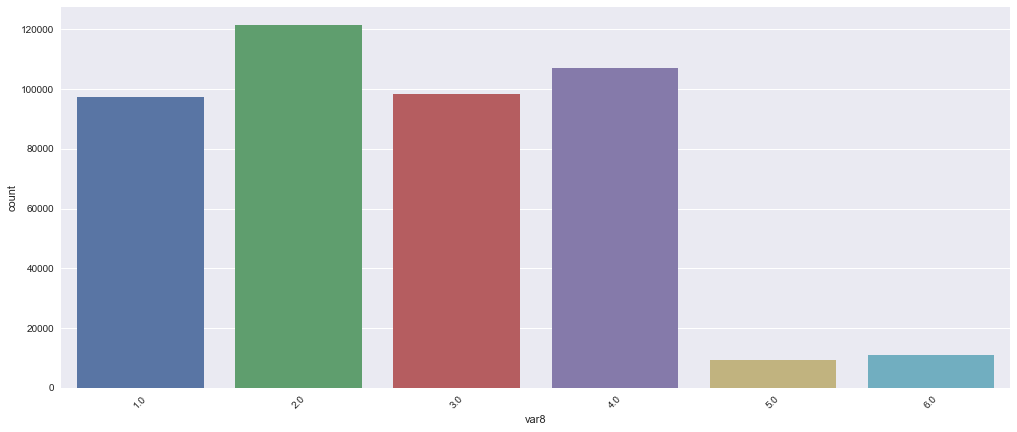

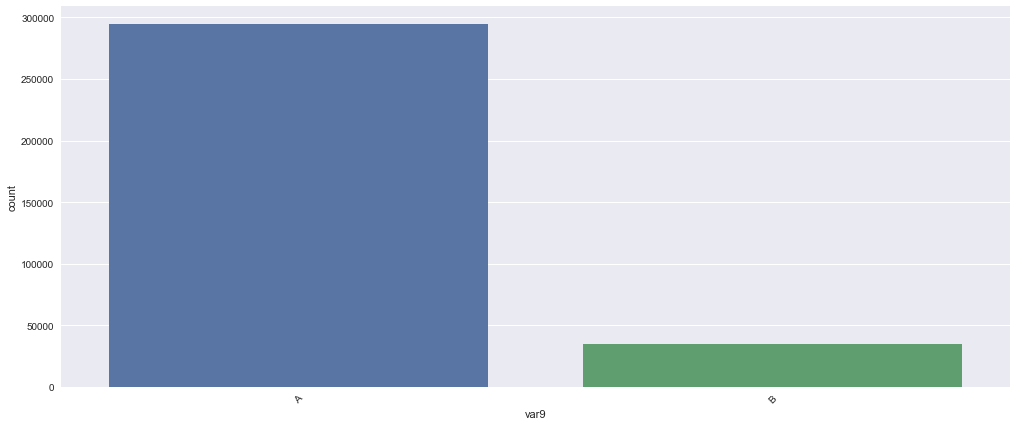

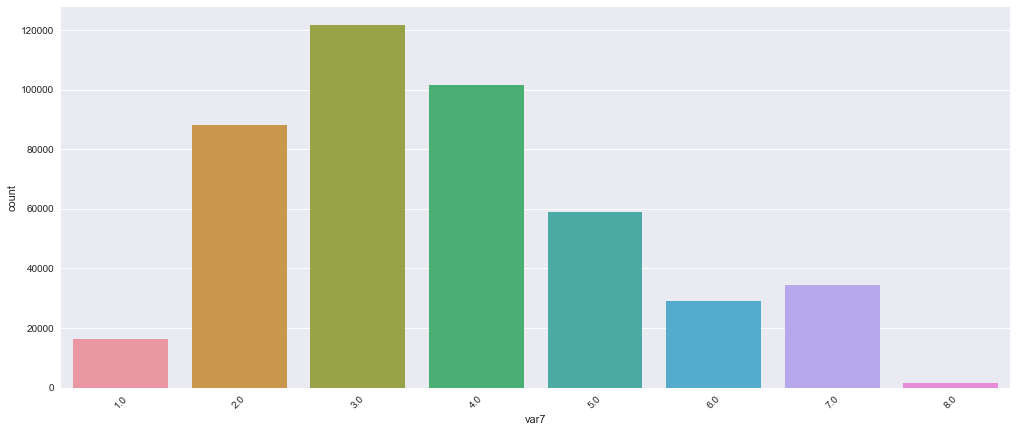

In [22]:
for c in intersection(ordinals + nominals,df.columns):
    draw_count_plot(c)

The boxbolots below show which variables are associated with the target variable. Note that there is little variability within the variables. For example. `var7`exhibits eight values which do not present a dependency of their variability with the `target` variable. The same is true vor `var8`.

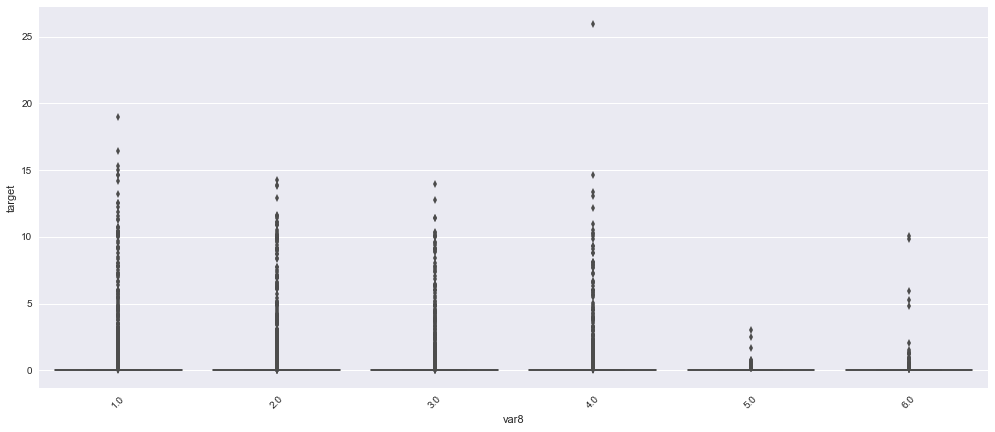

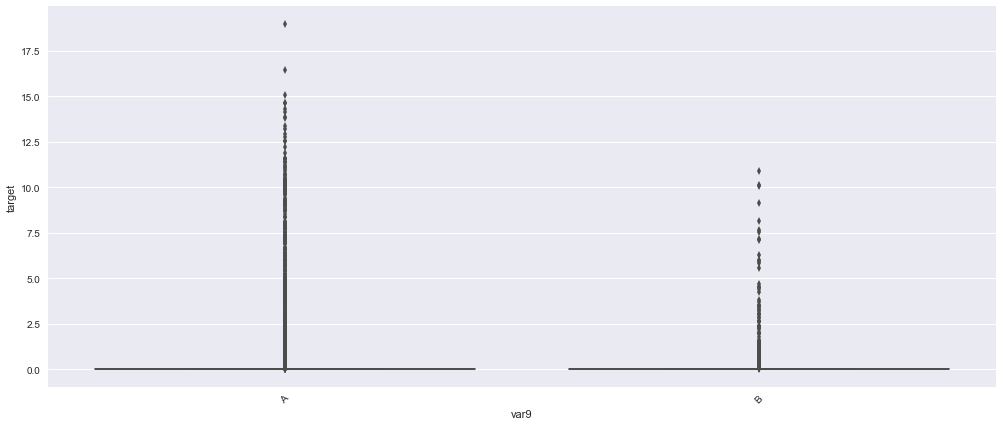

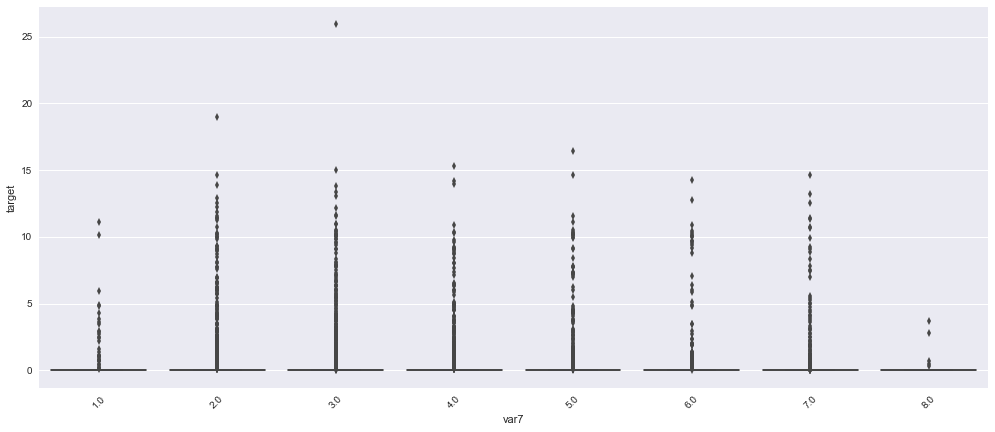

In [23]:
for c in intersection(nominals,df.columns):
    draw_box_plot(c)

Lastly, we try some correlation heatmaps. As can be seen below, they turn out to be rather useful. In particular, there are a lot of `weahter` variables that are correlated with each other. The brighter or darker spots of the heatmap show strong positive or negative correlation respectively. However, the sheer amount of these variables renders a manual selection process rather difficult.

Also, within the the weather variables, subgroups ot weather variables can be identified that bear high similarity among each other. They can be found by looking at the brighter or darker cluster that come in squaure shapes. This may justify the use of PCA to reduce the number of dimensions effectively without excessive loss of information.

In [24]:
# here, we put the differend kinds of weather, crime and geo variables intwo their own list
weather = list(df.columns[df.columns.str.contains('weather')])
crime = list(df.columns[df.columns.str.contains('crime')])
geo = list(df.columns[df.columns.str.contains('geo')])
var = list(df.columns[df.columns.str.contains(r'^var')])
var = difference(var+ordinals+nominals, to_drop)

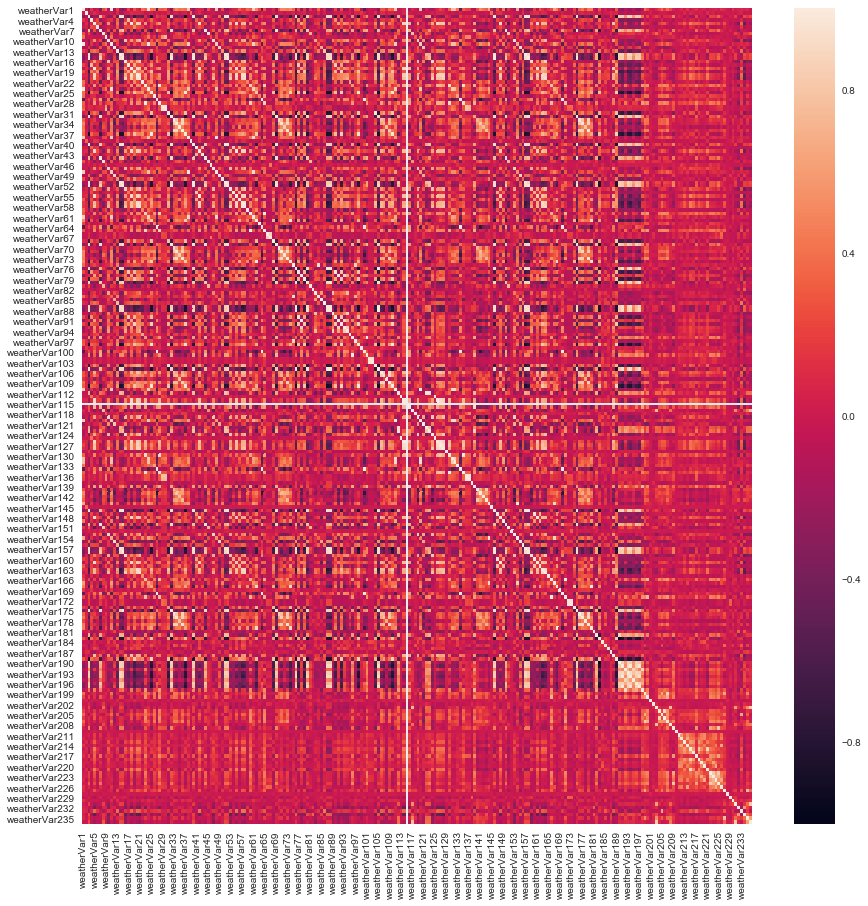

In [25]:
weather_r = df[weather].corr()
plt.figure(figsize = (15,15))
ax = sns.heatmap(weather_r, vmin=-1, vmax=1)

The geographical variables also seem to consist of clusters of variables that are highly positively or negatively correlated amon each other. This may support the use of PCA as a valid compression technique to reduce the number of variables.

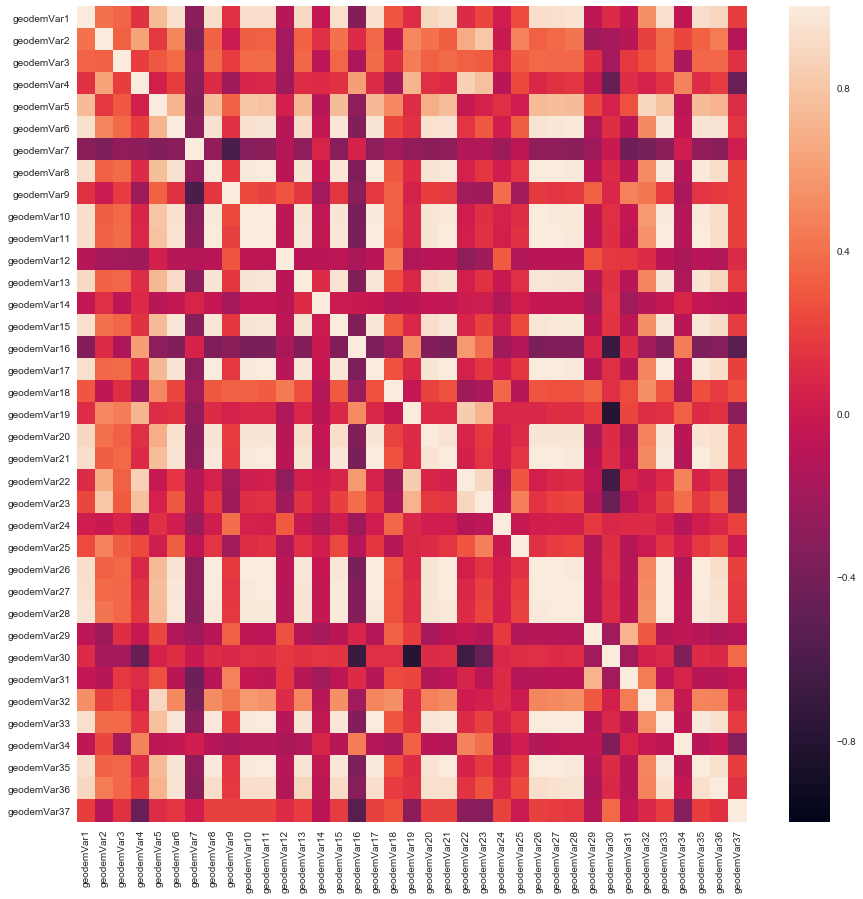

In [26]:
geo_r = df[geo].corr()
plt.figure(figsize = (15,15))
ax = sns.heatmap(geo_r, vmin=-1, vmax=1)

Most of the `crime` variables turn out to be rather highly correlated among each other. The heatmap presented below shows their interrelationships.

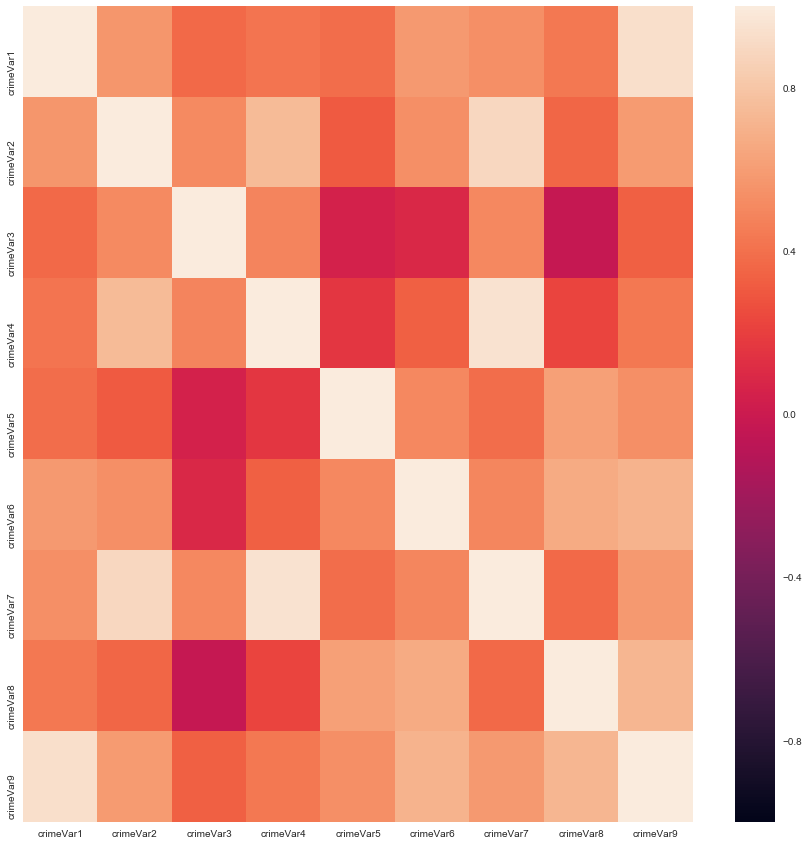

In [27]:
crime_r = df[crime].corr()
plt.figure(figsize = (15,15))
ax = sns.heatmap(crime_r, vmin=-1, vmax=1)

Now that we have imported, cleansed and explored the data, we now apply feature engineering techniques to prepare the data for the model building stage.

***
## 5. Feature Engineering & Encoding <a name="5"></a>

The following steps are being taken care of in this section:

1. Inspect target distribution and evaluate if it needs to be transformed
    - Censoring large claims
    - Downsampling of majority events
2. Create new features using feature compression techniques (e.g. PCA)
3. Encode all nominal variables using one-hot-encoding.
4. Encode ordinal feature to numeric representations

Note that cencoring large claims, downsampling of majority events and the use of PCA has been inspired by the winning team ***Datarobot*** as they outlined their approach in their [presentation](https://www.casact.org/education/rpm/2015/handouts/Paper_3897_handout_2469_0.pdf). However, the exact way has not been replicated in this capstone project as their source code is not publicly available.

### 5.1. Censoring Large Claims and Log-Transformation

The following two histograms show that the use of a log transform makes the target variable more normal. Also, the spike at the higher ends of the distribution will be taken out.

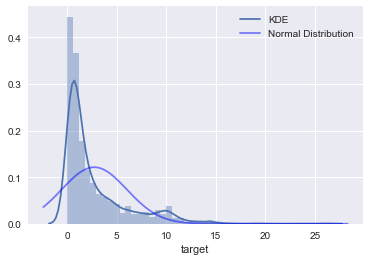

In [28]:
draw_hist(df[df['target']>0]['target'])

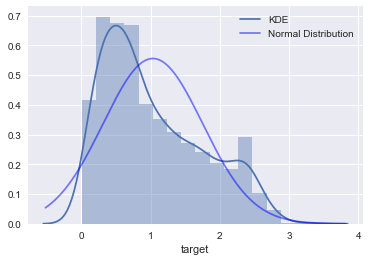

In [29]:
draw_hist(np.log(df[df['target']>0]['target']+1))

The following function will perform the two operations.

In [30]:
def censor_and_categorize(df):
    df = df.copy()
    upper_bound = df[df.target>0]['target'].quantile(0.80)
    df['target'] = [upper_bound if i > (upper_bound) else i for i in df.target]
    df['LogTarget'] = np.log(df['target']+1)
    df['isClaim'] = [1 if i > 0 else 0 for i in df.target]
    return df.copy()

### 5.2. Feature Compression: Principal Component Analysis

This function applies PCA on a set of variables. The argument `features` is a list of lists:  `[one_family_of_variables, another_family_of_variables]`. `feature_names'` which contains the names of the family of features we try to compress to a smaller representation. 

For example, if we input a list of three feature families, the three feature families will be compressed individually
so that the three families will be preserved but compressed in order to obtain two principal components per family.
    
Later, this function compresses the `weather`, `geo` and `crime` variables individually to obtain two principal components for the three categories of variables.

In [31]:
def compress_features(df, features, feature_names, pca_objects=None, scaling_objects=None):
    print('Compressing features...')
    df = df.copy()
    comp_feats  = []
    
    if (pca_objects==None): 
        pca_objects = []
        scaling_objects = []
        for i, cols in enumerate(features):
            scaler = StandardScaler().fit(df[cols])
            scaling_objects.append(scaler)
            scaled = scaler.transform(df[cols])
            pca = PCA(n_components=2)
            pca.fit(scaled)
            pca_objects.append(pca)
            pca = pca.transform(scaled)
            components = pd.DataFrame(pca, 
                                      columns=['pca_' + feature_names[i] + '_0', 
                                               'pca_' + feature_names[i] + '_1'
                                              ]
                                     )
            comp_feats.append(components)
    else:
        for i, cols in enumerate(features):
            scaled = scaling_objects[i].transform(df[cols])
            pca = pca_objects[i].fit_transform(scaled)
            components = pd.DataFrame(pca, columns=['pca_' + feature_names[i] + '_0', 'pca_' + feature_names[i] + '_1'])
            comp_feats.append(components)
            
    feature_components = pd.concat(comp_feats, axis=1)
    feature_components.reset_index(drop=True, inplace=True)
    return feature_components.copy(), pca_objects, scaling_objects

### 5.3. Downsampling of majority events

This function takes care of resampling the dataset. More precisely, only the subset of data will be resampled that does not exhibit a `target`-value `>0`. Since most target values are zero, only these rows will be resampled downwards (downsampled)  to balance out the **minority class** (`target > 0`) with the **majority class** (`target == 0`). 

In [32]:
def downsample(df, maj_min_ratio=1):
    print('Resampling...')
    from sklearn.utils import resample
    df = df.copy()

    # Separate majority and minority classes
    df_maj = df[df.LogTarget == 0]
    df_min = df[df.LogTarget > 0]

    # Downsample majority class
    df_maj_ds = resample(df_maj, 
                         replace = False,                         # sample without replacement
                         n_samples=len(df_min) * maj_min_ratio,   # to match minority class
                         random_state=0)                          # reproducible results

    # Combine minority class with downsampled majority class
    df = pd.concat([df_maj_ds, df_min], axis=0, ignore_index=True)
    return df.copy()

### 5.4. Perform Preprocessing

Finally, we actually apply all the defined functions from above and preprocess the training, validation and test set of the project.

In [33]:
def encode_features(df):
    print('Encoding features...')
    df = df.copy()
    info = get_df_overview(df, 'nulls pct')
    for c in info[info.dType=='category'].index:
        df[c] = df[c].cat.codes
    return df.copy()

In [34]:
def preprocess(df, features, mode, imputation_probabilities=None, pca_objects=None, scaling_objects=None):

    df = df.copy()
    df = split_column(df, 'var4')
    df = df.drop(intersection(features['To Drop'] + ['target'], df.columns), axis = 1)
    df, imputation_probabilities = impute_missing_values(df)
    cf, pca_objects, scaling_objects = compress_features(df, features['PCA']['PCA Features'], features['PCA']['PCA Feature Names'], pca_objects, scaling_objects)

    # variable separation
    if (mode=='Train'):
        targets = df[['LogTarget', 'isClaim']]
        targets.reset_index(drop=True, inplace=True)
        
        variables = df[features['Normal Variables']]
        variables.reset_index(drop=True, inplace=True)
        
        cf.reset_index(drop=True, inplace=True)
        df_long_comp = pd.concat([targets, variables, cf], axis=1)
        
        # sampling
        df_short = downsample(df, 10)
        df_short_comp = downsample(df_long_comp, 10)
        
        # conversions
        df = convert_categoricals(df)
        df = encode_features(df)

        df_long_comp = convert_categoricals(df_long_comp)
        df_long_comp = encode_features(df_long_comp)

        df_short = convert_categoricals(df_short)
        df_short = encode_features(df_short)

        df_short_comp = convert_categoricals(df_short_comp)
        df_short_comp = encode_features(df_short_comp)
        
        return_dict = {
            'long_wide': df,
            'short_wide': df_short,
            'long_comp': df_long_comp,
            'short_comp': df_short_comp,
        }
        
    elif (mode=='Validation'):
        targets = df[['LogTarget', 'isClaim']]
        targets.reset_index(drop=True, inplace=True)
        
        variables = df[features['Normal Variables']]
        variables.reset_index(drop=True, inplace=True)
        
        cf.reset_index(drop=True, inplace=True)
        df_long_comp = pd.concat([targets, variables, cf], axis=1)  
        
        # conversions
        df = convert_categoricals(df)
        df = encode_features(df)

        df_long_comp = convert_categoricals(df_long_comp)
        df_long_comp = encode_features(df_long_comp)

        return_dict = {
            'long_wide': df,
            'long_comp': df_long_comp
        }    

    elif (mode=='Test'):
        variables = df[features['Normal Variables']]
        variables.reset_index(drop=True, inplace=True)
        
        cf.reset_index(drop=True, inplace=True)
        df_long_comp = pd.concat([variables, cf], axis=1)  
        
        # conversions
        df = convert_categoricals(df)
        df = encode_features(df)

        df_long_comp = convert_categoricals(df_long_comp)
        df_long_comp = encode_features(df_long_comp)

        return_dict = {
            'long_wide': df,
            'long_comp': df_long_comp
        }     
    
    return return_dict, imputation_probabilities, pca_objects, scaling_objects

In [35]:
# here, we put the differend kinds of weather, crime and geo variables intwo their own list
# subsequently, the weather, criime and geo variables are compressed individually two obtain
# two principal components for the three categories of variables each.
weather = list(df.columns[df.columns.str.contains('weather')])
crime = list(df.columns[df.columns.str.contains('crime')])
geo = list(df.columns[df.columns.str.contains('geo')])
var = list(df.columns[df.columns.str.contains(r'^var')])
var = difference(var+ordinals+nominals, to_drop)

In [36]:
features = {
    'PCA': {
        'PCA Features': [crime, geo, weather],
        'PCA Feature Names': ['crime', 'geo', 'weather']
    },
    'To Drop': to_drop,
    'Normal Variables': var,
    'Weather Variables': weather,
    'Crime Variables': crime,
    'Geographic Variables': geo
}

In [37]:
df_train = censor_and_categorize(df)
df_train, df_valid = train_test_split(df_train, test_size=0.3, stratify=df_train['isClaim'], random_state=0)

In [38]:
df_train_dict, imputation_probabilities, pca_objects, scaling_objects = preprocess(df_train, features, 'Train')

Imputing missing values...
Compressing features...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data

Resampling...
Resampling...
Converting Variables...
Encoding features...
Converting Variables...
Encoding features...
Converting Variables...
Encoding features...
Converting Variables...
Encoding features...


In [39]:
df_valid_dict, _, _, _ = preprocess(df_valid, features, 'Validation', imputation_probabilities, pca_objects, scaling_objects)

Imputing missing values...
Compressing features...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.


Converting Variables...
Encoding features...
Converting Variables...
Encoding features...


In [40]:
df_test_dict, _, _, _ = preprocess(df_test, features, 'Test', imputation_probabilities, pca_objects, scaling_objects)

Imputing missing values...
Compressing features...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.


Converting Variables...
Encoding features...
Converting Variables...
Encoding features...


In [41]:
joblib.dump(df_train_dict, 'Data\df_train_dict.joblib')
joblib.dump(df_valid_dict, 'Data\df_valid_dict.joblib')
joblib.dump(df_test_dict, 'Data\df_test_dict.joblib')

['Data\\df_test_dict.joblib']

## 6. Model Evaluation Metric: Normalised Weighted Gini Coefficient<a name="6"></a>

In order to compare model performance with the official Kaggle leaderboard, we calculate the normalized, weighted Gini coefficient.

According to the Kaggle website, the normalized, weighted Gini coefficient is calculated as follows:

In [42]:
def weighted_gini(act,pred,weight): 
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight}) 
    df = df.sort_values('pred',ascending=False) 
    df["random"] = (df.weight / df.weight.sum()).cumsum() 
    total_pos = (df.act * df.weight).sum() 
    df["cumposfound"] = (df.act * df.weight).cumsum() 
    df["lorentz"] = df.cumposfound / total_pos 
    n = df.shape[0] 

    gini = sum(df.lorentz[1:].values * (df.random[:-1])) - sum(df.lorentz[:-1].values * (df.random[1:])) 
    return gini

In [43]:
def normalized_weighted_gini(act,pred,weight):
    return weighted_gini(act,pred,weight) / weighted_gini(act,act,weight)

***
## 7. Model Building <a name="7"></a>

In this section the predictive models are being built.

The first section oulines the process of how the predictive models are going to be built. The second section looks at how the individual lerners are trained. The third section looks at how the individual lerners are aggregated (stacked) to an ensemble of lerners. Lastly, all the individual models and their aggregations will be evaluated before the final prediction.

### 7.1. Model Building Process <a name="71"></a>

For building the model in this project, we distinguish between the `public` and `private` data set. While we know the regression target variable in the `public` data set, the target is completely unknown to us in the `private` data set. The `private` data set is used for the final predction and submission after the model has been build, evaluated, tuned and selected for production.

To build the model we take the `public` data set and split it into a `training` set, a `validation` set and a `test` set.

>- **Training Set:** Used to train the individual learners.
- **Validation:** The individual lerners make their prediction on the hold-out set and an `ensemble` lerner (meta lerner) will learn the weights put on every individual learner.
- **Test:** is not used to learn any relationship. Rather, this will be used to assess performance of the individual and ensemble models before it (or they) is used for the final (`private`) predictions.

<img style="float: left;" src="Pictures\Process.png" alt="drawing" width="918"/> 

The subsection below will outline that we will use six different variations of the original training set to train the models. Due to this, a custom `train_test()`-function is built to separate the individual training and test splits. The function returns a `dictionary` to properly handle the complexity of having multiple different splits.

In [44]:
def train_test(df, regression_y, classification_y, split_ratio):
    df = df.copy()
    X = df.drop([regression_y, classification_y], axis=1)
    X = pd.get_dummies(X, columns=intersection(nominals,X.columns), prefix=intersection(nominals,X.columns))
   
    y = df[regression_y]
    X_tr, X_te, y_reg_tr, y_reg_te = train_test_split(X, y, train_size=split_ratio, random_state=0, stratify=df[classification_y])

    y = df[classification_y]
    X_clf_tr, X_clf_te, y_clf_tr, y_clf_te = train_test_split(X, y, train_size=split_ratio, random_state=0, stratify=y)
    
    return {
                'X_tr': X_tr.copy(), 
                'X_te': X_te.copy(), 
                'y_reg_tr': y_reg_tr.copy(), 
                'y_reg_te': y_reg_te.copy(), 
                'y_clf_tr': y_clf_tr.copy(), 
                'y_clf_te': y_clf_te.copy()
           }

The function below performs automatic feature selection using six voters (regressors and classifiers) that vote on the dataset and assess wheather or not a particular variable is usefull:
- ***`uv`:*** is a statistical univariate test based on `ANOVA`. `01`, `005` are the significance levels (p-values) upon which a variable is considered different from zero
- Furthermore, several other linear classifiers with L1 penalty are used.

Finally, a feature is considered `good` if it receives **at least four votes**.

In [45]:
def select_best_features(X_tr, y_reg_tr, y_clf_tr, save_features, refresh=True):
    if refresh:
        
        features = pd.DataFrame({'Column': X_tr.columns})
        
        X_tr = X_tr.copy().values
        y_reg_tr = y_reg_tr.copy().values
        y_clf_tr = y_clf_tr.copy().values
        X_sp = sparse.coo_matrix(X_tr)
        
        selector_clf = SelectKBest(f_classif, k = 'all').fit(X_tr, y_clf_tr)

        features['uv_clf_alpha_01'] = (selector_clf.pvalues_ < 0.1)
        features['uv_clf_alpha_005'] = (selector_clf.pvalues_ < 0.05)
        features['uv_clf_alpha_001'] = (selector_clf.pvalues_ < 0.01)
        features['Randomized Lasso'] = RandomizedLasso(random_state = 0).fit(X_tr, y_reg_tr).get_support()
        features['Linear SVC'] = (LinearSVC(C=0.1, penalty = "l1", dual = False, random_state = 0, class_weight='balanced').fit(X_tr, y_clf_tr).coef_>0).reshape(-1)
        features['Logistic Regregssion'] = (LogisticRegression(C=0.01, penalty = 'l1', random_state = 0, class_weight='balanced').fit(X_tr, y_clf_tr).coef_>0).reshape(-1)
        features['Votes'] = features.sum(axis=1)
        features['Good Feature'] = features.Votes >= 4
    else:
        features = pd.read_csv(save_features)
        
    good_features = list(features[features['Good Feature']==True].Column)
    features.to_csv(save_features, index=False)
    
    return good_features, features

Now we prepare the six different datasets. The six different training sets will be explained in further detail in the next paragraph.

In [46]:
refresh = False
training_dict = {} # create a dictionary of different training sets
training_dict['long_wide'] = train_test(df_train_dict['long_wide'], 'LogTarget', 'isClaim', 0.8) 

good_features_long, features_long = select_best_features(training_dict['long_wide']['X_tr'], 
                                               training_dict['long_wide']['y_reg_tr'], 
                                               training_dict['long_wide']['y_clf_tr'],
                                               'Features\Features_long.csv', refresh
                                              )

training_dict['short_wide'] = train_test(df_train_dict['short_wide'], 'LogTarget', 'isClaim', 0.8) 
training_dict['long_comp'] = train_test(df_train_dict['long_comp'], 'LogTarget', 'isClaim', 0.8) 
training_dict['short_comp'] = train_test(df_train_dict['short_comp'], 'LogTarget', 'isClaim', 0.8)

training_dict['long_selected'] = training_dict['long_wide'].copy()
training_dict['long_selected']['X_tr'] = training_dict['long_selected']['X_tr'][good_features_long].copy()

good_features_short, features_short = select_best_features(training_dict['short_wide']['X_tr'], 
                                               training_dict['short_wide']['y_reg_tr'], 
                                               training_dict['short_wide']['y_clf_tr'],
                                               'Features\Features_short.csv', refresh
                                              )

training_dict['short_selected'] = training_dict['short_wide'].copy()
training_dict['short_selected']['X_tr'] = training_dict['short_selected']['X_tr'][good_features_short].copy()

In [47]:
joblib.dump(training_dict, 'Data\\training_data.joblib')

['Data\\training_data.joblib']

### 7.2. Regression & Classification Ensemble <a name="72"></a>

After having outlined the process of how we are going to build our ensemble. The figure below illustrates the ensemble building strategy.

First, we will train several regression and classification algorithms on the data set. Every single algorithm is trained with different versions of the training dataset:

>- **Original Dataset:** Original training set that has been cleansed and one-hot encoded (data set `long_wide`)
- **Compressed Dataset:** Original dataset where the geo, weather and crime variables have been compressed using PCA (data set `long_comp`)
- **Resampled Dataset:** Downsampled versions where the majority events are downsampled to a majority-to-minority ratio of 10 (data set `short_wide`).
- **Resampled & Compressed:** Downsampled data set that has been compressed using PCA for the geo, weather and crime variables (data set `short_comp`).
- **Selected Features:** Original dataset, but features are reduced using automatic feature selection (function `select_best_features()` (data set `long_selected`).
- **Selected & Resampled:** Downsampled dataset dataset that has been reduced in width as well using automatic feature selection (data set `short_selected`).

In the following figure, the matrices below the regression and classification algorithms indicate in green if the dataset is used to train this particular model. Grey means that the algorithm is not trained on this specific data set. For classification, note that we only use the long (not resampled) versions of the training data as we will only use classifiers that implement a `class_weight`-parameter. The `class_weight` parameter puts inversely proportional weights on the errors of the majority and minitory class to balance out the classification accuracy. Therefore, we will only use Logistic Regression, Extra Trees, Random Forest and Linear SVC.

It should be pointed out that every learner is trained using 5-Fold Cross validation and Grid Search.

Once the individual learners have been trained, all the learners will make predictions on the validation (hold-out) set. After having made all predictions (`46 predictions in total`), we will fit a all these 46 regression and classification outputs to a new ***meta learner***. This meta learner will assign a coefficient to each individual prediction made by the individual learners.  These coefficients (or weights) are illustrated by the brightness of the orange tiles. Good individual learners will become a higher weight (darker), while weak learners will be a assigned a lower weight (and, hence, will be brighter).

<img style="float: left;" src="Pictures\Strategy.png" alt="drawing" width="1259"/> 

In [48]:
class Model:
    # this custom class implements a function 'fit' that fits a model to a list of data sets that is specified using the
    # parameter 'datasets'. Also, the constructor receives the regression or classification 'model' to fit the data to, 
    # a grid search dictionary, and some descriptive attributes such as model_type, model_name.  
    # the parameters 'cv' and 'verbose' are passed to GridSearchCV().
    # The fitted models are stored in the dictionary 'fits' that contains the fitted models per dataset within 
    # a `Model`-object.
    def __init__(self, model_type, model_name, model, grid, datasets, cv, verbose):
        self.model_type = model_type
        self.model_name = model_name
        self.model = model
        self.grid = grid
        self.datasets = datasets
        self.cv = cv
        self.verbose = verbose
        self.fits = {}
        
    def fit(self):
        for ds_key, dataset in self.datasets.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', self.model)
            ])

            gs = GridSearchCV(pipe, self.grid, cv=self.cv, verbose=self.verbose)
            X = dataset['X_tr']
            
            if self.model_type=='Regression':
                y = dataset['y_reg_tr']
            else:
                y = dataset['y_clf_tr']

            print('Fitting', self.model_name, 'on data set', ds_key, 'with shape', X.shape, '...')
            self.fits[ds_key] = gs
            self.fits[ds_key].fit(X, y)

In [49]:
# in this cell, we prepare the arguments for instanciating objects of the class 'Model'. 
# first, we prepare a list of different data sets for the objects of the class 'Model'.
# Then, we define the grid search dictionaries.

all_sets = ['long_wide', 'short_wide', 'long_comp', 'short_comp', 'long_selected', 'short_selected']
small_sets = ['long_comp', 'short_comp', 'long_selected', 'short_selected']
long_sets = ['long_wide', 'long_comp', 'long_selected']

all_data = {key:training_dict[key] for key in all_sets}
small_data = {key:training_dict[key] for key in small_sets}
long_data = {key:training_dict[key] for key in long_sets}

# grid search dictionaries
ols_grid = {'model__fit_intercept': [True]}
lr_grid = {'model__alpha': np.logspace(-6,6,10)}
svr_grid = {'model__C': [1,2,4]}

rf_grid = {
    'model__n_estimators': [500],
    'model__max_depth': [5],
    'model__min_samples_leaf': [5]
}

gbr_grid = {
    'model__learning_rate': [0.001],
    'model__n_estimators': [500],
    'model__max_depth': [5],
    'model__min_samples_leaf': [5]
}

xgbr_grid = {
    'model__min_child_weight': [0.9], 
    'model__gamma': [0.4],  
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.9], 
    'model__max_depth': [4]
}

log_reg_grid = {
    'model__penalty': ['l1'], 
    'model__max_iter': [1000], 
    'model__class_weight': ['balanced']
}

xt_grid = {
    'model__n_estimators': [300], 
    'model__class_weight': ['balanced']
}

rf_clf_grid = {
    'model__n_estimators': [300], 
    'model__class_weight': ['balanced']
}

svc_grid = {
    'model__class_weight': ['balanced']
}

In [50]:
# Now, we define a dictionary 'ensemble' which we use to instaciate our objects of the class 'Model'
# and we pass the constructor arguments for proper initialisation.

ensemble = {
    'LinearRegression': Model('Regression', 'LinearRegression', LinearRegression(), ols_grid, all_data, 5, 0),
    'Lasso': Model('Regression', 'Lasso', Lasso(random_state=0), lr_grid, all_data, 5, 0),
    'Ridge': Model('Regression', 'Ridge', Ridge(random_state=0), lr_grid, all_data, 5, 0),
    'RandomForestRegression': Model('Regression', 'RandomForestRegression', RandomForestRegressor(random_state=0), rf_grid, small_data, 5, 0),
    'GradientBoostingRegression': Model('Regression', 'GradientBoostingRegression', GradientBoostingRegressor(random_state=0), gbr_grid, small_data, 5, 0),
    'XGBoostRegression': Model('Regression', 'XGBRegression', XGBRegressor(random_state=0), xgbr_grid, small_data, 5, 0),
    'LinearSVR': Model('Regression', 'LinearSVR', LinearSVR(random_state=0), svr_grid, small_data, 5, 0),
    
    'LogisticRegression': Model('Classification', 'LogisticRegression', LogisticRegression(random_state=0), log_reg_grid, long_data, 5, 0),
    'ExtraTreesClassifier': Model('Classification', 'ExtraTreesClassifier', ExtraTreesClassifier(random_state=0), xt_grid, long_data, 5, 0),
    'RandomForestClassifier': Model('Classification', 'RandomForestClassifier', RandomForestClassifier(random_state=0), rf_clf_grid, long_data, 5, 0),
    'SVC': Model('Classification', 'LinearSVC', LinearSVC(random_state=0), svc_grid, long_data, 5, 0)
}

In [51]:
# Now that our models have been instanciated, we call the method 'fit()' on every object of the class 'Model'
# in the 'ensemble' dictionary.
# after every iteration, we delete the datasets in the 'Model'-objects
# to spare storage space and save the model to a file.
for key, model in ensemble.items():
    model.fit()
    model.datasets = None
    joblib.dump(model, 'Models\\' + str(model.model_type) + '_' + str(model.model_name) + '.joblib')

Fitting LinearRegression on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting LinearRegression on data set short_wide with shape (7321, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting LinearRegression on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting LinearRegression on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting LinearRegression on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting LinearRegression on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting Lasso on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Us

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

Fitting Lasso on data set short_wide with shape (7321, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Us

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Us

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Fitting Lasso on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting Lasso on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = tr

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting Lasso on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Us

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

Fitting Lasso on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Fitting Ridge on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting Ridge on data set short_wide with shape (7321, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting Ridge on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting Ridge on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting Ridge on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting Ridge on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:4

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Fitting RandomForestRegression on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting RandomForestRegression on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting RandomForestRegression on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting RandomForestRegression on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting GradientBoostingRegression on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting GradientBoostingRegression on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting GradientBoostingRegression on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting GradientBoostingRegression on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting XGBRegression on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting XGBRegression on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting XGBRegression on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting XGBRegression on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting LinearSVR on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-pa

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-pa

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-pa

Fitting LinearSVR on data set short_comp with shape (7321, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\b

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\b

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\b

Fitting LinearSVR on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:6

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionW

Fitting LinearSVR on data set short_selected with shape (7321, 30) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionW

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionW

Fitting LogisticRegression on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting LogisticRegression on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting LogisticRegression on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting ExtraTreesClassifier on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting ExtraTreesClassifier on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting ExtraTreesClassifier on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting RandomForestClassifier on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting RandomForestClassifier on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2

Fitting RandomForestClassifier on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preproces

Fitting LinearSVC on data set long_wide with shape (253153, 331) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:

Fitting LinearSVC on data set long_comp with shape (253153, 55) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-pa

Fitting LinearSVC on data set long_selected with shape (253153, 66) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:

In [52]:
# code to recover models, if needed
# ensemble = {
#     'LinearRegression': joblib.load('Models\\Regression_LinearRegression.joblib'),
#     'Lasso': joblib.load('Models\\Regression_Lasso.joblib'),
#     'Ridge': joblib.load('Models\\Regression_Ridge.joblib'),
#     'RandomForestRegression': joblib.load('Models\\Regression_RandomForestRegression.joblib'),
#     'GradientBoostingRegression': joblib.load('Models\\Regression_GradientBoostingRegression.joblib'),
#     'XGBoostRegression': joblib.load('Models\\Regression_XGBRegression.joblib'),
#     'LinearSVR': joblib.load('Models\\Regression_LinearSVR.joblib'),
    
#     'LogisticRegression': joblib.load('Models\\Classification_LogisticRegression.joblib'),
#     'ExtraTreesClassifier': joblib.load('Models\\Classification_ExtraTreesClassifier.joblib'),
#     'RandomForestClassifier': joblib.load('Models\\Classification_RandomForestClassifier.joblib'),
#     'SVC': joblib.load('Models\\Classification_LinearSVC.joblib')
# }

# training_dict = joblib.load('Data\\training_data.joblib')
# df_valid_dict = joblib.load('Data\\df_valid_dict.joblib')

### 7.3. Ensembling: Ensemble Stacking & Blending <a name="73"></a>

After having trained all models successfully, we now make predictions on the validation (hold-out) dataset using all fitted models in all variations. By doing that, we obtain 56 different predictions per observations. Note that for the classification models, we compute both the classification probability as well as the classification itself.

The following figure shows in orange the hold-out set with its features (301 features in the long and wide version and less in the compressed and reduced versions). To the right of the hold-out set, we see the predictions made row by row for every model. Every column to the right of the hold-out set is a different prediction from a different algorithm.

<img style="float: left;" src="Pictures\holdout.png" alt="drawing" width="1734"/> 

In [53]:
def predict(df_long_wide, df_long_comp, ensemble):
    # this function receives a wide and a compressed version of a test or validation dataset along with a dictionary of 
    # individually trained models.
    # the function returns a dataframe with a column per model giving their prediction (classification and regression).
    
    df_long_wide = df_long_wide.copy()
    df_long_comp = df_long_comp.copy()
    df_ensemble = pd.DataFrame()
    
    for key, model in ensemble.items():
        for dataset, fit in model.fits.items():

            if 'comp' in dataset:
                X = df_long_comp
            else:
                X = df_long_wide

            #X = pd.get_dummies(X, columns=intersection(nominals,X.columns), prefix=intersection(nominals,X.columns))
            X = X.reindex(columns = training_dict[dataset]['X_tr'].columns, fill_value=0)

            # predict and prepare df_ensemble for final regression
            col = model.model_name + '_' + dataset

            if model.model_type=='Regression':
                df_ensemble[col + '_reg'] = fit.predict(X)
                #df_ensemble[np.abs(df_ensemble[col + '_reg']) < 0.00002] = 0
            else:
                df_ensemble[col + '_clf'] = fit.predict(X)
                try:
                    df_ensemble[col + '_prob'] = fit.predict_proba(X)[:,1]
                except:
                    pass # --> ignore predictors that do not implement the predict_proba()-method.
                
    reg_cols = [col for col in df_ensemble.columns if '_reg' in col]
    prob_cols = [col for col in df_ensemble.columns if '_prob' in col]
    clf_cols = [col for col in df_ensemble.columns if '_clf' in col]
    
    # besides now compute the mean across all regressors, the mean probability and mean classification
    # for all classifiers. Then we take the mean regressor value and weight it by the mean probability prediction.
    # lastly, we weight the regression mean by the majority vote, which is either zero or one
    # this way, we get three different kind of ensemble predictions
    df_ensemble['Regressor Mean'] = df_ensemble[reg_cols].mean(axis=1)
    df_ensemble['Probability Mean'] = df_ensemble[prob_cols].mean(axis=1)  
    df_ensemble['Majority Vote'] = round(df_ensemble[clf_cols].mean(axis=1),0)
    df_ensemble['Mean Probability Weighted Regression Mean'] = df_ensemble['Regressor Mean'] * df_ensemble['Probability Mean']
    df_ensemble['Majority Vote Weighted Regression Mean'] = df_ensemble['Regressor Mean'] * df_ensemble['Majority Vote']

    return df_ensemble.copy()

In [54]:
# df_valid_dict['long_comp']['LogTarget'] = df_valid_dict['long_wide'].reset_index()['LogTarget'].copy()
# df_valid_dict['long_comp']['isClaim'] = df_valid_dict['long_wide'].reset_index()['isClaim'].astype(int).copy()

In [55]:
# we split the validation data set into a training and testing set in order to properly validate our results.
df_valid_long_wide = train_test(df_valid_dict['long_wide'], 'LogTarget', 'isClaim', 0.8)
df_valid_long_comp = train_test(df_valid_dict['long_comp'], 'LogTarget', 'isClaim', 0.8)

print('Hold-out Training Size', df_valid_long_wide['X_tr'].shape)
print('Hold-out Validation Size', df_valid_long_wide['X_te'].shape)

Hold-out Training Size (108495, 331)
Hold-out Validation Size (27124, 331)


In [56]:
y_train = pd.DataFrame({'isClaim': df_valid_long_wide['y_reg_tr'], 'LogTarget': df_valid_long_wide['y_clf_tr']})     
ensemble_predictions = predict(df_valid_long_wide['X_tr'], df_valid_long_comp['X_tr'], ensemble)

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: D

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConver

In [57]:
df_ensemble_train = pd.concat([ensemble_predictions.reset_index(), y_train.reset_index()], axis=1).drop('index', axis=1)

In [58]:
df_ensemble_train.head()

LinearRegression_long_wide_reg  LinearRegression_short_wide_reg  \
0  0.000768                        0.017345                          
1  0.004801                        0.154033                          
2  0.002108                        0.063656                          
3 -0.000791                       -0.042553                          
4  0.004938                        0.112575                          

   LinearRegression_long_comp_reg  LinearRegression_short_comp_reg  \
0  0.000454                        0.015511                          
1  0.004102                        0.131692                          
2  0.000311                        0.015023                          
3  0.000209                       -0.005515                          
4  0.003360                        0.095742                          

   LinearRegression_long_selected_reg  LinearRegression_short_selected_reg  \
0  0.000603                            0.030339                              
1  0.004929                            0.162782                              
2  0.000201                            0.001374                              
3  0.000771                            0.015950                              
4  0.004042                            0.127885                              

   Lasso_long_wide_reg  Lasso_short_wide_reg  Lasso_long_comp_reg  \
0  0.001679             0.044245              0.000593              
1  0.003257             0.130926              0.004134              
2  0.001765             0.044047              0.000273              
3  0.001854             0.052359              0.000675              
4  0.002436             0.081264              0.003252              

   Lasso_short_comp_reg  Lasso_long_selected_reg  Lasso_short_selected_reg  \
0  0.018158              0.000696                 0.026978                   
1  0.132942              0.004467                 0.159577                   
2  0.015067              0.000435                 0.006519                   
3  0.002497              0.001020                 0.022473                   
4  0.094652              0.003783                 0.122422                   

   Ridge_long_wide_reg  Ridge_short_wide_reg  Ridge_long_comp_reg  \
0  0.001041             0.020487              0.000626              
1  0.004837             0.133897              0.003947              
2  0.001346             0.055392              0.000443              
3  0.000638             0.032528              0.001112              
4  0.004457             0.116454              0.003120              

   Ridge_short_comp_reg  Ridge_long_selected_reg  Ridge_short_selected_reg  \
0  0.021655              0.000939                 0.034857                   
1  0.122592              0.004156                 0.137183                   
2  0.021107              0.000573                 0.018712                   
3  0.036017              0.001446                 0.042219                   
4  0.090484              0.003576                 0.112784                   

   RandomForestRegression_long_comp_reg  \
0  0.000840                               
1  0.003103                               
2  0.001013                               
3  0.000985                               
4  0.003845                               

   RandomForestRegression_short_comp_reg  \
0  0.027703                                
1  0.157558                                
2  0.032137                                
3  0.036830                                
4  0.089389                                

   RandomForestRegression_long_selected_reg  \
0  0.001041                                   
1  0.003485                                   
2  0.001092                                   
3  0.001119                                   
4  0.003098                                   

   RandomForestRegression_short_selected_reg  \
0  0.039390                                    
1  0.141384          

The above dataframe `df_ensemble` holds predictions that were made on the **validation** set. In the next section, these individual prediction will be used to build a **meta regressor** that use the **individual regressor predictions** as its **features**.

### 7.4. Ensembling: Training a Meta Learner<a name="74"></a>

In this section we train several meta learners. The meta learner is a regression that uses the individual predictions of the target variable as a feature. The idea behind the meta learner is to capture the influence of each of these meta learners and adjust their prediction to more generaly fit the model.

<img style="float: left;" src="Pictures\meta.png" alt="drawing" width="2286"/> 

We also perform an automatic feature selection for an automatic evaluation of which learners may be particularly useful. The same function is used as above where we created the data set `long_selected` and `short_selected`.

In [59]:
good_predictors, predictors = select_best_features(df_ensemble_train.drop(['LogTarget', 'isClaim'], axis=1), 
                                               df_ensemble_train.LogTarget, 
                                               df_ensemble_train.isClaim.astype(int),
                                               'Models\\Predictors.csv', True
                                              )

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [48 53 54] are constant.
  UserWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Memory is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Parallel is deprecated; deprecated in version 0.20.1 to be removed in ve

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed

In [60]:
# since we use the same interface as above to train the new meta learners, we have to put our newly built meta training sets
# into a dictionary so that the objects of the class `Model` can read them.
# first, we put a set of all individual lerners. The second training set is a subset consisting only of good predictors
# as evaluated by the automatic (meta) features selector function select_best_features().
meta_train_dict= {}
temp = {}
temp['X_tr'] = df_ensemble_train.drop(['LogTarget', 'isClaim'], axis=1)
temp['y_reg_tr'] = df_ensemble_train.LogTarget
meta_train_dict['ensemble'] = temp

temp = {}
temp['X_tr'] = df_ensemble_train[good_predictors]
temp['y_reg_tr'] = df_ensemble_train.LogTarget
meta_train_dict['selected_ensemble'] = temp

# prepare grid as expected for the model constructor
lr_grid = {'model__alpha': np.logspace(-6,6,10)}

en_grid = {'model__max_iter': [1, 5, 10],
              'model__alpha': np.logspace(-6,6,10),
              'model__l1_ratio': np.arange(0.0, 1.0, 0.1)
          }

# define the set of meta predictors we would like to evaluate
meta_predictors = {
    'LinearRegression': Model('Regression', 'LinearRegression', LinearRegression(), ols_grid, meta_train_dict, 5, 0),
    'Lasso': Model('Regression', 'Lasso', Lasso(random_state=0), lr_grid, meta_train_dict, 5, 0),
    'Ridge': Model('Regression', 'Ridge', Ridge(random_state=0), lr_grid, meta_train_dict, 5, 0),
    'ElasticNet': Model('Regression', 'ElasticNet', ElasticNet(random_state=0), en_grid, meta_train_dict, 5, 0)
}

In [61]:
# train the meta predictors
for key, model in meta_predictors.items():
    model.fit()
    model.datasets = None
    joblib.dump(model, 'Models\\' + 'MetaPredictor_' + str(model.model_name) + '.joblib')

Fitting LinearRegression on data set ensemble with shape (108495, 60) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting LinearRegression on data set selected_ensemble with shape (108495, 33) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting Lasso on data set ensemble with shape (108495, 60) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting Lasso on data set selected_ensemble with shape (108495, 33) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting Ridge on data set ensemble with shape (108495, 60) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting Ridge on data set selected_ensemble with shape (108495, 33) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting ElasticNet on data set ensemble with shape (108495, 60) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt =

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

Fitting ElasticNet on data set selected_ensemble with shape (108495, 33) ...


C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problem

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_f

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\alexd\Anaconda3.6\envs\exts-

### 7.4. Ensembling: Validating the Meta Learner <a name="74"></a>

Having trained all the individual models, the (weighted) average ensemble predictors as well as our meta learners, this subsection presents the performance of all models how they perform on the held-out test set, which has never been used before.

In [62]:
# this function receives a dataframe with all prediction variations as its columns plus the true target value for evaluation
# since we need to compare our model based on the normalized weighted gini coefficient, the weight used for comparison is 
# var11.

# the function returns a dataframe showing 
    # the normalized weighted gini coefficient 
    # model type (individual regressor or classifier or ensemble)
    # weight (weight is calculated based on the normalized weighted gini coefficient)
        # per model type (Regressor, Classifier, Ensemble), all weights sum up to 1. The weights are used to build a 
        # version of an ensemble, which will be the gini weighted regression ensemble, where we take 
        # the weighted average of all predictions and multiply
        # this value by the gini weighted probability of being a loss from all classification probabilities.
def get_scores(df, weights):
    df = df.copy()
    weights = weights.copy()
    winners = []
    cols = []

    for col in list(df.columns):
        gini = normalized_weighted_gini(
            np.exp(np.float64(df.LogTarget))-1, 
            np.exp(np.float64(df[col]))-1, 
            weights
        )

        cols.append(col)
        winners.append(gini)

    df_win = pd.DataFrame({'gini': winners}, index=cols).drop(['LogTarget', 'isClaim'])
    df_win = df_win.sort_values('gini', ascending=False)
    
    df_win['model type'] = ['Regressor' if ('_reg' in i) else 'Classifier' if ('_prob' in i) else 'Ensemble' for i in df_win.index]
    df_win['weight'] = df_win.groupby('model type').gini.apply(normalizer)
    df_win = df_win.rename(index=str, columns={'index': 'column'})
    
    return df_win.copy()

In [63]:
def normalizer(x):
    # this function is used to convert the normalised weighted gini scores into weights that sum to one
    norm = 1 / sum(x)
    return x * norm

In [64]:
def gini_weighted_ensemble(df, df_scores):
    # this function weights the individual predictions as obtained from the individual learners and weights these
    # predictions by the gini score obtained by the model.
    # the weightings are done separately for regression and classification models
    # finally, the gini-weighted regression prediction is weighted by the gini-weighted classification probability
    
    df = df.copy()
    df_scores = df_scores.copy()
    reg_cols = [col for col in df.columns if '_reg' in col]
    prob_cols = [col for col in df.columns if '_prob' in col]

    regressors = df[reg_cols].reindex(sorted(df[reg_cols].columns), axis=1)
    regressor_weights = df_scores[df_scores['model type']=='Regressor'].sort_index(axis=1).T.loc['weight']
    #regressor_weights[regressor_weights < 0] = 0
    weighted_avg_regressor = (regressor_weights.values * regressors.values).sum(axis=1)

    classifiers = df[prob_cols].reindex(sorted(df[prob_cols].columns), axis=1)
    classifier_weights = df_scores[df_scores['model type']=='Classifier'].sort_index(axis=1).T.loc['weight']
    #classifier_weights[classifier_weights < 0] = 0
    weighted_avg_classifier = (classifier_weights.values * classifiers.values).sum(axis=1)
    
    return (weighted_avg_regressor * weighted_avg_classifier).copy()

In [65]:
# first, we perform the individual predictions from the individual learners
valid_predictions = predict(df_valid_long_wide['X_te'], df_valid_long_comp['X_te'], ensemble)

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: D

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarni

In [66]:
y_valid = pd.DataFrame({'isClaim': df_valid_long_wide['y_reg_te'], 'LogTarget': df_valid_long_wide['y_clf_te']}) 
df_ensemble_valid = pd.concat([valid_predictions.reset_index(), y_valid.reset_index()], axis=1).drop('index', axis=1)

In [67]:
# now, we add the meta learners, which add their predictions to the data frame
X_meta = df_ensemble_valid.drop(['LogTarget', 'isClaim'], axis=1)
y_meta = df_ensemble_valid.LogTarget

for key, model in meta_predictors.items():
    for dataset, fit in model.fits.items():
        X_meta = X_meta.reindex(columns = meta_train_dict[dataset]['X_tr'].columns, fill_value=0)
        if dataset=='selected_ensemble':
            df_ensemble_valid['MetaRegressor' + '_selected_' + model.model_name] = fit.predict(X_meta)
        else:
            df_ensemble_valid['MetaRegressor' + '_' + model.model_name] = fit.predict(X_meta)

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\skle

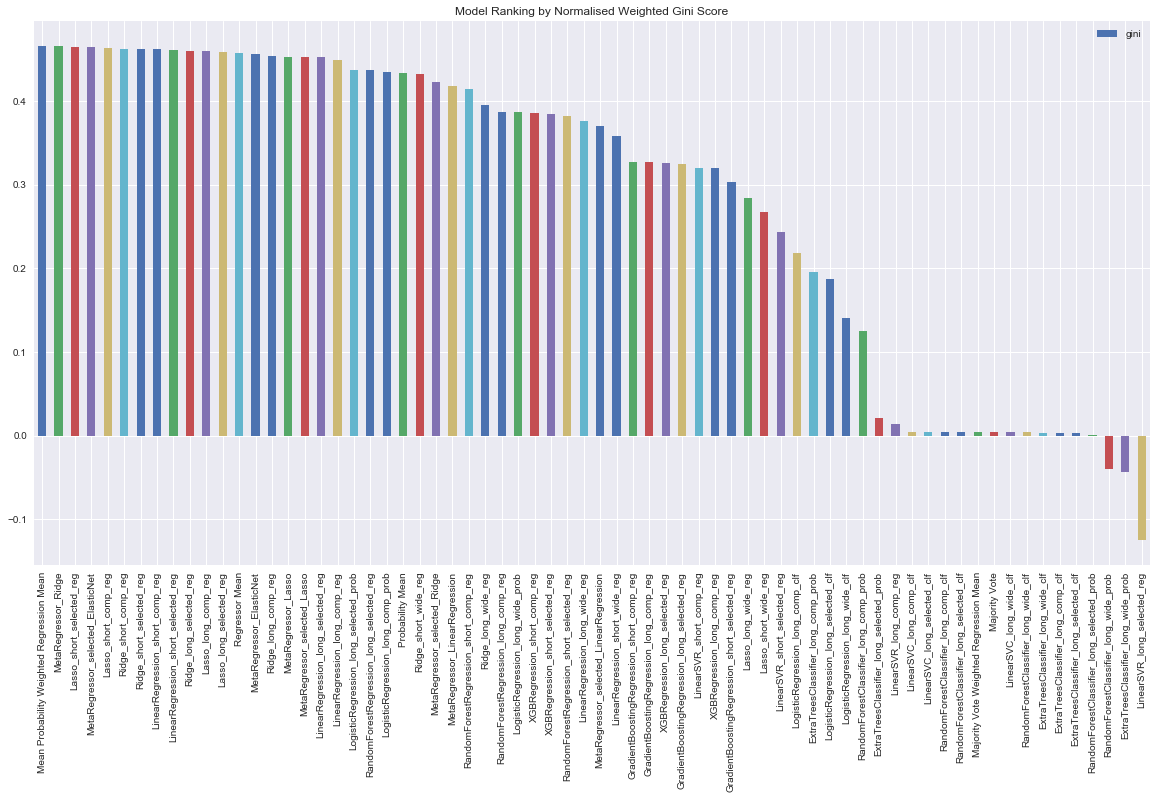

In [68]:
# lets compare the scores
df_scores = get_scores(df_ensemble_valid, df_valid_long_wide['X_te'].var11)
df_scores.plot.bar(y='gini', figsize=(20,10), title='Model Ranking by Normalised Weighted Gini Score')

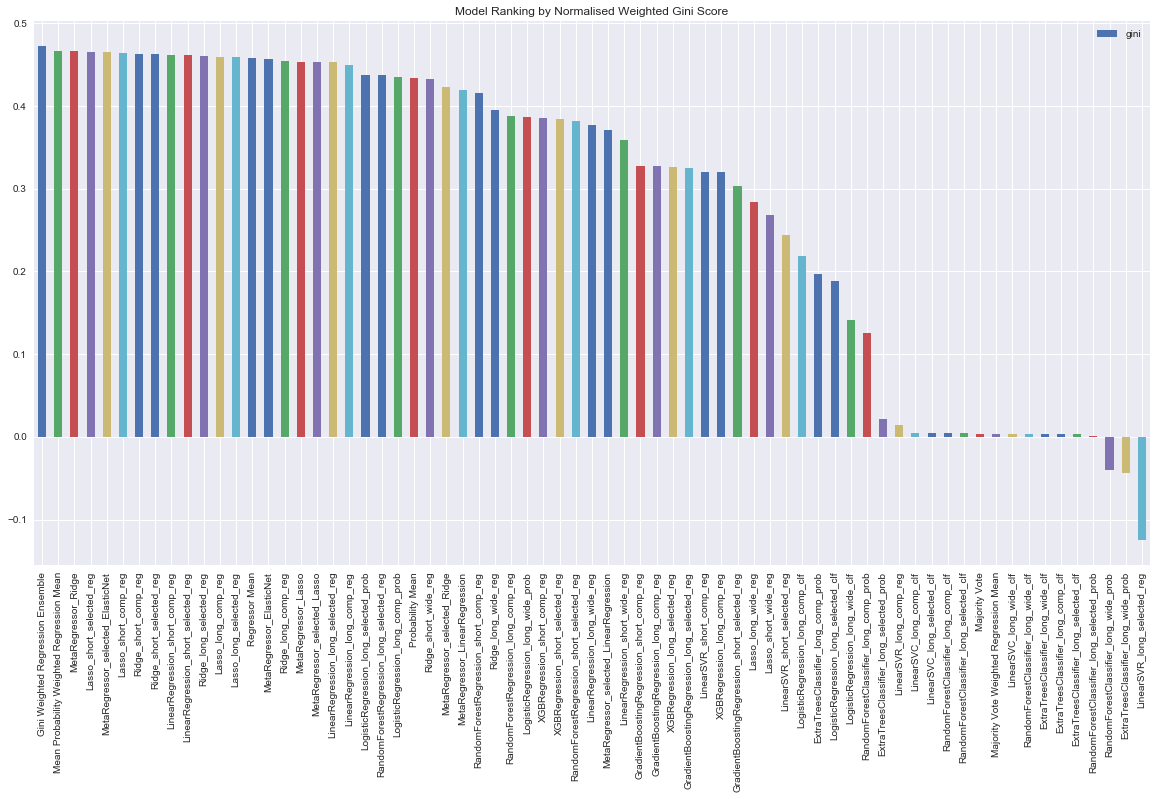

In [69]:
# now we add the gini weighted regression ensemble
df_ensemble_valid['Gini Weighted Regression Ensemble'] = gini_weighted_ensemble(df_ensemble_valid, df_scores)
df_scores = get_scores(df_ensemble_valid, df_valid_long_wide['X_te'].var11)
df_scores.plot.bar(y='gini', figsize=(20,10), title='Model Ranking by Normalised Weighted Gini Score')

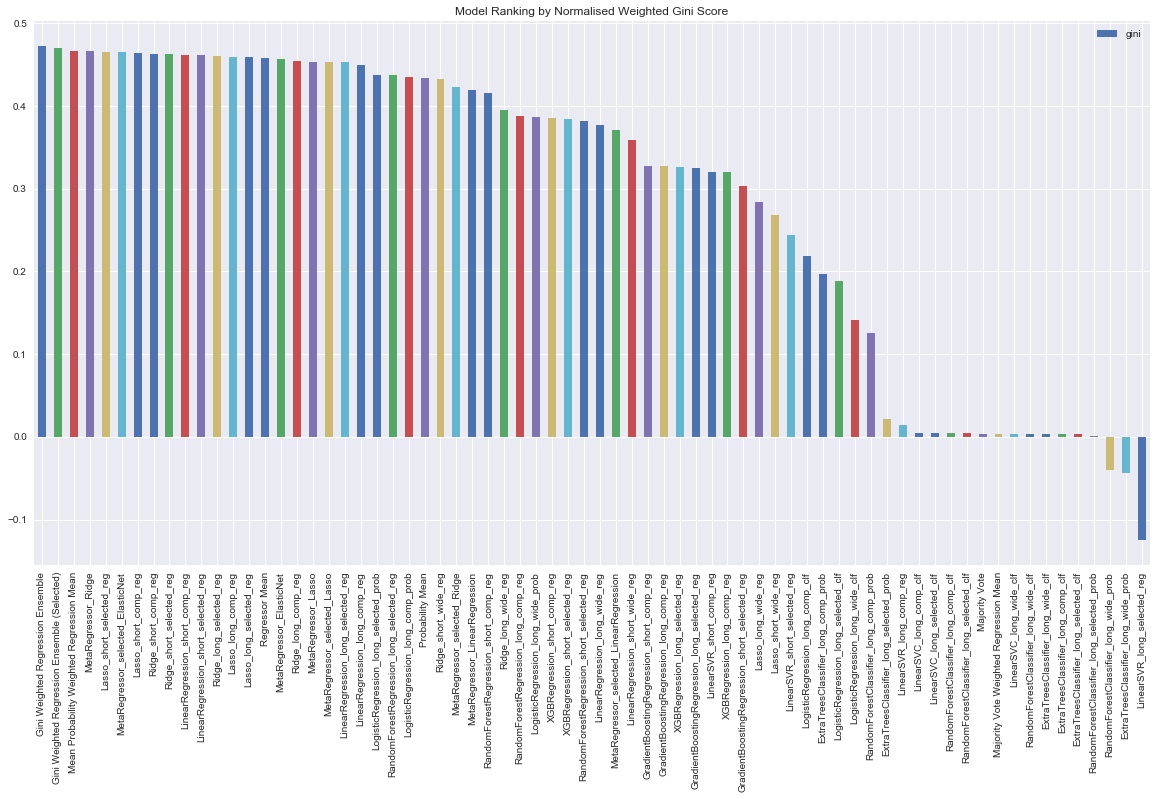

In [70]:
# lastly, we compute the gini weighted regression ensemble but only based on the meta features that have been 
# automatically identified and selected as being 'good'.
df_ensemble_valid['Gini Weighted Regression Ensemble (Selected)'] = gini_weighted_ensemble(df_ensemble_valid[good_predictors], df_scores.loc[good_predictors])
df_scores = get_scores(df_ensemble_valid, df_valid_long_wide['X_te'].var11)
df_scores.plot.bar(y='gini', figsize=(20,10), title='Model Ranking by Normalised Weighted Gini Score')

In [78]:
df_scores.head(10)

gini model type    weight
Gini Weighted Regression Ensemble             0.472582  Ensemble   0.073910
Gini Weighted Regression Ensemble (Selected)  0.469600  Ensemble   0.073444
Mean Probability Weighted Regression Mean     0.466181  Ensemble   0.072909
MetaRegressor_Ridge                           0.465821  Ensemble   0.072853
Lasso_short_selected_reg                      0.465178  Regressor  0.037515
MetaRegressor_selected_ElasticNet             0.465070  Ensemble   0.072735
Lasso_short_comp_reg                          0.463569  Regressor  0.037385
Ridge_short_comp_reg                          0.462702  Regressor  0.037315
Ridge_short_selected_reg                      0.462514  Regressor  0.037300
LinearRegression_short_comp_reg               0.461805  Regressor  0.037243

>The data frame `df_scores` shows that the top 5 models performed all better than the best teams on the [public leaderboard](https://www.kaggle.com/c/liberty-mutual-fire-peril/leaderboard) on Kaggle.


<img style="float: left;" src="Pictures\leaderboard.jpg" alt="drawing" width="927"/> 

In [72]:
# we simply select the best model based on its rank in the dataframe.
winner = df_scores.index[0]
print('Winner:', df_scores.index[0])

Winner: Gini Weighted Regression Ensemble


***
##  8. Final Predictions & Submission <a name="8"></a>

Here, we submit the final predictions.

In [73]:
final_predictions = predict(df_test_dict['long_wide'], df_test_dict['long_comp'], ensemble)

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: D

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:381: DataConver

In [74]:
X = final_predictions

for key, model in meta_predictors.items():
    for dataset, fit in model.fits.items():
        X = X.reindex(columns = meta_train_dict[dataset]['X_tr'].columns, fill_value=0)
        if dataset=='selected_ensemble':
            final_predictions['MetaRegressor' + '_selected_' + model.model_name] = fit.predict(X)
        else:
            final_predictions['MetaRegressor' + '_' + model.model_name] = fit.predict(X)

C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\alexd\Anaconda3.6\envs\exts-aml2\lib\site-packages\skle

In [75]:
final_predictions['Gini Weighted Regression Ensemble'] = gini_weighted_ensemble(final_predictions, df_scores)
final_pred = final_predictions[winner]

In [76]:
df_submission = pd.DataFrame()
df_submission['id'] = df_test.id
df_submission['target'] = np.exp(np.float64(final_pred))-1

In [77]:
df_submission.to_csv('Data\\df_submission.csv')

***
##  9. Conclusion & Discussion <a name="9"></a>

The following two secions conclude the capstone project and summarise the major findings.

## 9.1 Conclusion
Having gone through the entire process of preparing, cleansing, exploring, feature engineering, model building and, finally, evaluating and computing the final predictions, several observations have been made.

While we went through building a very large and complex ensemble of predictors for regression and classification, the model that ultimately was chosen as the "winning" model, was indeed the evaluation score (gini) weighted regression ensemble. However, note that the top 10 also included less complex models that used reduced data sets either by means of automatic feature selection, automatic feature compression (using PCA) or a resampled (downsampled) data set.

Following the objectives of this project, several observations have been made:

***Automated feature engineering:***
PCA was used on three groups of features. However, there may be numerous ways how feature engineering could be automated. Models that used feature compression were fairly prominent in the top 5 in `df_scores`.


***Automated variable selection:***
The function `select_best_features()`implements automatic feature selection based on a majority vote of different regressors and classifiers. This function appears to have been very useful and effective in the model building process as the second best model builds upon this function, which reached second place using simple linear regression.


***Automated model selection:***
Model selection has been automated as well. Automatic model selection has been facilitated by the custom written class `Model` which allows for efficient and simple initialisation and training of multiple models that can be stored in a list or dictionary. Subsequently, the models can be looped through and evaluated based on the metric at hand. In this case, we used the `normalized_weighted_gini()`-function to evaluate model performance.


***Automated ensemble building:***
Not only have we constructed one ensemble, we have constructed several variants of ensembles:

- Simple mean of all regressors
- Mean probability weighted mean of all regressors
- Gini weighted mean probability weighted regressors (winner)
- Majority vote weighted mean regression 

Having said all that, it remains open for further disussion which model finally should be used in a productive environment. Most probably, this depends on non functional requirements such as performance (speed of prediction), explainability or maintainability. The gini weighted mean regression ensemble may have serval advantages and disadvantages.

***Advantages***
- Accuracy
- Reduced bias through averaging of multiple predictors and probabilistic features
- Robustness through the inclusion of a high number of independend predictors 

***Disadvantages***
- Complex model building process
- Long training time
- Smaller training set due to the creation of a hold-out set that needs to be split into validation and test set.


## 9.2 Discussion

During the process of this capstone project, several learnings have happened. Hence, for a more comprehensive and extensive approach of solving the problem presented in this capstone project, the following steps may be necessary:

***Parallel Computing Functions***
>The custom-built class `Model` should implement multithreaded execution of its functions as this would speed up the training process significantly.

***Exhaustive Grid Search***
>Although the grid search has been implemented in order to find optimal model hyperparameters, the chosen parameter space was deliberately limited (to a lenght of one) in order for the models to be trained in an acceptable amount of time.  


***Automated feature engineering:***
Automated feature engineering could be extended the following ways:
>- An engine that automatically calculates products, ratios, reciprocals, polynomials on combinations of variables
>- Automatically computes a number of principal components to be used based on an explained variance threshold.


***Variable Transformations***
>Using automatic power transformations (box-cox or yeo-johnson) of the variables might impose more symmentry and normality to the variables, which would improve learning as well. However, during the course of the project, this was not looked at. For a productive setup, however, this should be looked at more carefully.

***K-Fold Cross Validation for Ensembles***
>The python library `mlxtend` implements the use of meta regressors that can use the regular sklearn API and built-in features such as grid search and cross validation. In a productive environment, a library of this sort may be beneficial. Using standard libraries icreases efficiency, maintainability as well parsimony of source code. 

***Extensive Feature Engineering and Subject Matter Knowledge***
>If the semantics of the provided features had been known to the data scientist or machine learning engineer, manual 
feature engineering may be a very valuable source of extra performance and accuracy of the model.

***
##  10. References <a name="9"></a>

- [Datarobot](https://www.casact.org/education/rpm/2015/handouts/Paper_3897_handout_2469_0.pdf)
- [Downsampling](https://elitedatascience.com/imbalanced-classes)
- [Kaggle Competition Site](https://www.kaggle.com/c/liberty-mutual-fire-peril)
- [Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/)
- [Meta Regression Examples](https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho)